In [1]:
# Libraries imports
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
from typing import Dict, List, Tuple, Optional
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                            roc_auc_score, mean_squared_error, mean_absolute_error, r2_score)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [2]:
# CONFIGURATION
class fMRIConfig:    
    #def __init__(self, base_path: str = r'E:\Intermediate\BACON_ERIC\Head_neck\fMRI\Neck-Tumor_data\PATIENTS'):
    def __init__(self, base_path: str = r'E:\Head_neck\fMRI'):
        self.base_path = Path(base_path)
        self.data_dir = self.base_path  
        #self.label_path = self.base_path / 'DATA' / 'labels'
        self.label_path = self.base_path  / 'labels'
        self.subject_list = list(range(1, 33))
        self.activation_types = ['sensory', 'AN', 'LN', 'cognitive', 'DMN']
        self.connectivity_types = ['DMN']
        self.agg_method = 'both'  
        
        self.hidden_dim = 64    
        self.fusion_dim = 128
        self.dropout = 0.4
        self.num_classes = 2  
        
        self.batch_size = 8
        self.num_epochs = 100
        self.learning_rate = 1e-4
        self.weight_decay = 1e-4
        self.patience = 15
        self.n_splits = 5
        self.val_ratio = 0.15 
        self.grad_clip = 1.0
        
        self.output_dir = Path('./results_fmri')
        self.checkpoint_dir = Path('./checkpoints_fmri')
        self.log_dir = Path('./logs_fmri')
        for dir_path in [self.output_dir, self.checkpoint_dir, self.log_dir]:
            dir_path.mkdir(parents=True, exist_ok=True)
    
    def __repr__(self):
        return (f"fMRIConfig(subjects={len(self.subject_list)}, "
                f"activation={self.activation_types}, "
                f"connectivity={self.connectivity_types}, "
                f"agg={self.agg_method}, val_ratio={self.val_ratio})")

In [ ]:
# ========= DATA LOADING==========
def load_activation_features(data_dir: Path, subject_list: List[int], activation_types: List[str],
                             agg_method: str = 'mean') -> Dict[int, torch.Tensor]:
    features = {}
    missing_files = []
    for subj in tqdm(subject_list, desc="Loading activation features"):
        subj_features = []
        subj_dir = data_dir / f'sub-{subj}'
        for act_type in activation_types:
            filepath = subj_dir / f"subject_{subj}_activation_{act_type}.csv"
            if not filepath.exists():
                missing_files.append(str(filepath))
                continue
            try:
                df = pd.read_csv(filepath)
                if 'Subject' in df.columns:
                    df = df.drop('Subject', axis=1)
                data = df.values.astype(np.float32)
                data = np.nan_to_num(data, nan=0.0)
                if agg_method == 'mean':
                    agg_data = np.mean(data, axis=0)
                elif agg_method == 'std':
                    agg_data = np.std(data, axis=0)
                elif agg_method == 'both':
                    agg_data = np.concatenate([np.mean(data, axis=0), np.std(data, axis=0)])
                else:
                    raise ValueError(f"Unknown aggregation method: {agg_method}")
                subj_features.append(agg_data)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")
                continue
        if subj_features:
            concat_features = np.concatenate(subj_features)
            features[subj] = torch.tensor(concat_features, dtype=torch.float32)
    print(f"\nActivation Features Summary:")
    print(f"  Loaded: {len(features)}/{len(subject_list)} subjects")
    if features:
        sample_feat = list(features.values())[0]
        print(f"  Feature dimension: {sample_feat.shape[0]}")
    if missing_files:
        print(f"  Missing files: {len(missing_files)}")
    return features

# Conenctivity data 
def load_connectivity_features(data_dir: Path, subject_list: List[int], connectivity_types: List[str]) -> Dict[int, torch.Tensor]:
    features = {}
    missing_files = []
    for subj in tqdm(subject_list, desc="Loading connectivity features"):
        subj_features = []
        subj_dir = data_dir / f'sub-{subj}'
        for conn_type in connectivity_types:
            filepath = subj_dir / f"subject_{subj}_fdr_PPI_Connectivity_{conn_type}.csv"
            if not filepath.exists():
                missing_files.append(str(filepath))
                continue
            try:
                df = pd.read_csv(filepath)
                if 'Subject' in df.columns:
                    df = df.drop('Subject', axis=1)
                data = df.values.astype(np.float32).flatten()
                data = np.nan_to_num(data, nan=0.0)
                subj_features.append(data)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")
                continue
        if subj_features:
            concat_features = np.concatenate(subj_features)
            features[subj] = torch.tensor(concat_features, dtype=torch.float32)
    print(f"\nConnectivity Features Summary:")
    print(f"  Loaded: {len(features)}/{len(subject_list)} subjects")
    if features:
        sample_feat = list(features.values())[0]
        print(f"  Feature dimension: {sample_feat.shape[0]}")
    if missing_files:
        print(f"  Missing files: {len(missing_files)}")
    return features

# Labels data 
def load_labels(label_path: Path, subject_list: List[int], binary: bool = True) -> Tuple[Dict[int, int], Optional[Dict[int, float]]]:
    class_labels = {}
    reg_labels = {}
    label_files = [label_path / 'labels.csv', label_path / 'outcomes.csv', 
                   label_path / 'subjects_labels.csv', label_path.parent / 'labels.csv']
    label_file = None
    for lf in label_files:
        if lf.exists():
            label_file = lf
            break
    if label_file is None:
        print("\n  WARNING: No label file found. Using dummy labels for testing.")
        for subj in subject_list:
            class_labels[subj] = np.random.randint(0, 2)
            reg_labels[subj] = np.random.randn()
        return class_labels, reg_labels
    df = pd.read_csv(label_file)
    print(f"\nLabels loaded from: {label_file}")
    print(f"  Columns: {df.columns.tolist()}")
    subj_col = None
    for col in ['Subject', 'subject', 'SubjectID', 'subject_id', 'ID', 'id']:
        if col in df.columns:
            subj_col = col
            break
    label_col = None
    for col in ['Label', 'label', 'Outcome', 'outcome', 'Class', 'class', 'Group', 'group']:
        if col in df.columns:
            label_col = col
            break
    reg_col = None
    for col in ['Score', 'score', 'Value', 'value', 'Continuous', 'continuous']:
        if col in df.columns:
            reg_col = col
            break
    if not subj_col or not label_col:
        raise ValueError(f"Could not identify subject or label columns in {label_file}")
    for _, row in df.iterrows():
        subj = int(row[subj_col])
        if subj not in subject_list:
            continue
        label = row[label_col]
        if binary:
            if isinstance(label, str):
                label = 1 if label.lower() in ['good', 'positive', 'yes', '1'] else 0
            else:
                label = int(label)
        class_labels[subj] = label
        if reg_col and reg_col in row:
            reg_labels[subj] = float(row[reg_col])
    print(f"\nLabel Summary:")
    print(f"  Classification labels: {len(class_labels)}")
    print(f"  Unique classes: {set(class_labels.values())}")
    if reg_labels:
        print(f"  Regression labels: {len(reg_labels)}")
    return class_labels, reg_labels if reg_labels else None

In [4]:
# FUSION DATASET
class fMRIDataset(Dataset):    
    def __init__(self, activation_features: Dict[int, torch.Tensor], connectivity_features: Dict[int, torch.Tensor],
                 class_labels: Dict[int, int], reg_labels: Optional[Dict[int, float]] = None, transform=None):
        self.transform = transform
        self.samples = []
        act_subjects = set(activation_features.keys())
        conn_subjects = set(connectivity_features.keys())
        label_subjects = set(class_labels.keys())
        common_subjects = act_subjects & conn_subjects & label_subjects
        print(f"\nDataset Construction:")
        print(f"  Activation subjects: {len(act_subjects)}")
        print(f"  Connectivity subjects: {len(conn_subjects)}")
        print(f"  Labeled subjects: {len(label_subjects)}")
        print(f"  Complete data: {len(common_subjects)}")
        for subj in sorted(common_subjects):
            sample = {'activation': activation_features[subj],'connectivity': connectivity_features[subj],'class_label': class_labels[subj],
                      'reg_label': reg_labels[subj] if reg_labels and subj in reg_labels else 0.0, 'subject': subj}
            self.samples.append(sample)
        print(f"  Final dataset size: {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        activation = sample['activation'] 
        connectivity = sample['connectivity']
        class_label = sample['class_label'] 
        reg_label = sample['reg_label']
        subject = sample['subject']
        if self.transform:
            activation = self.transform(activation)
            connectivity = self.transform(connectivity)
        return activation, connectivity, class_label, reg_label, subject 

def collate_fmri(batch):
    activations = torch.stack([item[0] for item in batch])
    connectivities = torch.stack([item[1] for item in batch])
    class_labels = torch.tensor([item[2] for item in batch], dtype=torch.long)
    reg_labels = torch.tensor([item[3] for item in batch], dtype=torch.float32)
    subjects = [item[4] for item in batch]
    return activations, connectivities, class_labels, reg_labels, subjects

In [ ]:
# ========== fMRI SUBJECT DATA HANDLER ==========
class fMRISubjectDataHandler:
    """Centralizes label loading, feature aggregation, normalization,
    splitting, and per-subject tracking for fMRI LOSO evaluation."""

    def __init__(self, config):
        self.config = config
        self.activation_features = {}
        self.connectivity_features = {}
        self.class_labels = {}
        self.reg_labels = {}
        self.subject_ids = []
        self.subject_labels = {}

    def load_all(self):
        """Load activation features, connectivity features, and labels."""
        self.activation_features = load_activation_features(
            self.config.data_dir, self.config.subject_list,
            activation_types=self.config.activation_types,
            agg_method=self.config.agg_method)

        self.connectivity_features = load_connectivity_features(
            self.config.data_dir, self.config.subject_list,
            connectivity_types=self.config.connectivity_types)

        self.class_labels, self.reg_labels = load_labels(
            self.config.label_path, self.config.subject_list)

        # Compute subject intersection across all modalities
        act_subjs = set(self.activation_features.keys())
        conn_subjs = set(self.connectivity_features.keys())
        label_subjs = set(self.class_labels.keys())
        common = act_subjs & conn_subjs & label_subjs
        self.subject_ids = sorted(common)
        self.subject_labels = {s: self.class_labels[s] for s in self.subject_ids}

        print(f"fMRISubjectDataHandler: {len(self.subject_ids)} subjects with complete data")
        label_counts = {}
        for v in self.subject_labels.values():
            label_counts[v] = label_counts.get(v, 0) + 1
        print(f"  Label distribution: {label_counts}")

    def build_dataset(self):
        """Build fMRIDataset from stored features."""
        ds = fMRIDataset(
            self.activation_features, self.connectivity_features,
            self.class_labels, self.reg_labels)
        return ds

    def get_subject_ids_and_labels(self):
        ids = np.array(self.subject_ids)
        labs = np.array([self.subject_labels[s] for s in self.subject_ids])
        return ids, labs

    def get_subject_split_indices(self, dataset, held_out_subjects):
        """Return (train_indices, test_indices) for a given held-out set."""
        held_set = set(int(s) for s in held_out_subjects)
        train_idx = [i for i, s in enumerate(dataset.samples)
                     if int(s['subject']) not in held_set]
        test_idx = [i for i, s in enumerate(dataset.samples)
                    if int(s['subject']) in held_set]
        return train_idx, test_idx

print("fMRISubjectDataHandler defined")


In [5]:
# ENCODER BLOCKS
class ActivationEncoder(nn.Module):
    def __init__(self, num_layers, in_dim, hidden_dim, dropout):
        super().__init__()
        self.project = nn.Linear(in_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim*4, 
            dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = self.project(x).unsqueeze(1)
        x = self.transformer(x)
        return self.norm(x.squeeze(1))

class ConnectivityEncoder(nn.Module):
    def __init__(self, num_layers, in_dim, hidden_dim, dropout):
        super().__init__()
        self.project = nn.Linear(in_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim*4, 
                                                   dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = self.project(x).unsqueeze(1)
        x = self.transformer(x)
        return self.norm(x.squeeze(1))

In [6]:
# FUSION DATASET
class fMRIFusionDataset(Dataset):    
    def __init__(self, activation_features: Dict[int, torch.Tensor], connectivity_features: Dict[int, torch.Tensor],
                 class_labels: Dict[int, int], reg_labels: Optional[Dict[int, float]] = None, transform=None):
        self.transform = transform
        self.samples = []
        act_subjects = set(activation_features.keys())
        activa = ActivationEncoder(act_subjects)
        conn_subjects = set(connectivity_features.keys())
        conn =ConnectivityEncoder(conn_subjects)
        label_subjects = set(class_labels.keys())
        common_subjects = act_subjects & conn_subjects & label_subjects
        
        print(f"\nDataset Construction:")
        print(f"  Activation subjects: {len(act_subjects)}")
        print(f"  Connectivity subjects: {len(conn_subjects)}")
        print(f"  Labeled subjects: {len(label_subjects)}")
        print(f"  Complete data: {len(common_subjects)}")
        
        for subj in sorted(common_subjects):
            sample = {'activation': activation_features[subj],'connectivity': connectivity_features[subj],'class_label': class_labels[subj],
                      'reg_label': reg_labels[subj] if reg_labels and subj in reg_labels else 0.0, 'subject': subj
                                              }
            self.samples.append(sample)
        print(f"  Final dataset size: {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        activation = sample['activation'] 
        connectivity = sample['connectivity']
        class_label = sample['class_label'] 
        reg_label = sample['reg_label']
        subject = sample['subject']
        if self.transform:
            activation = self.transform(activation)
            connectivity = self.transform(connectivity)
        return activation, connectivity, class_label, reg_label, subject 

def collate_fmri(batch):
    activations = torch.stack([item[0] for item in batch])
    connectivities = torch.stack([item[1] for item in batch])
    class_labels = torch.tensor([item[2] for item in batch], dtype=torch.long)
    reg_labels = torch.tensor([item[3] for item in batch], dtype=torch.float32)
    subjects = [item[4] for item in batch]
    return activations, connectivities, class_labels, reg_labels, subjects

In [7]:
class fMRIActivationOnly(nn.Module):    
    def __init__(self, in_dim: int, hidden_dim: int = 64, num_classes: int = 2, 
                 dropout: float = 0.4, task: str = 'classification', num_layers: int = 2):
        super().__init__()
        self.task = task
        
        # FIX: Pass all 4 required positional arguments to the updated ActivationEncoder
        # Signature: ActivationEncoder(num_layers, in_dim, hidden_dim, dropout)
        self.encoder = ActivationEncoder(num_layers, in_dim, hidden_dim, dropout)
        
        if task == 'classification':
            self.head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, num_classes)
            )
        else:
            self.head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            )
    
    def forward(self, activation, connectivity=None):
        """
        Note: 'connectivity' is included as a dummy argument to ensure compatibility 
        with training loops that pass both modalities to all models.
        """
        feat = self.encoder(activation)
        output = self.head(feat)
        
        if self.task == 'regression':
            output = output.squeeze(-1)
            
        return output
    
class fMRIConnectivityOnly(nn.Module):    
    def __init__(self, in_dim: int, hidden_dim: int = 64, num_classes: int = 2, 
                 dropout: float = 0.4, task: str = 'classification', num_layers: int = 2):
        super().__init__()
        self.task = task
        
        # FIX: Pass 4 positional arguments to match the updated ConnectivityEncoder signature
        # Signature: ConnectivityEncoder(num_layers, in_dim, hidden_dim, dropout)
        self.encoder = ConnectivityEncoder(num_layers, in_dim, hidden_dim, dropout)
        
        if task == 'classification':
            self.head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, num_classes)
            )
        else:
            self.head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            )
    
    def forward(self, activation=None, connectivity=None):
        """
        Processes connectivity data while ignoring activation input 
        for compatibility with the joint training loop.
        """
        # Ensure connectivity is provided
        if connectivity is None and activation is not None:
             # Logic to handle if inputs are swapped or just provided as first arg
             feat = self.encoder(activation)
        else:
             feat = self.encoder(connectivity)
             
        output = self.head(feat)
        
        if self.task == 'regression':
            output = output.squeeze(-1)
            
        return output

In [8]:
# FUSION MODEL
class fMRIFusionNet(nn.Module):
    def __init__(self, activation_dim: int, connectivity_dim: int, hidden_dim: int = 64,
                 num_classes: int = 2, dropout: float = 0.3, num_transformer_layers: int =2, num_heads: int = 4, task: str = 'classification'):
        super().__init__()
        self.task = task
        self.activation_encoder = ActivationEncoder(num_transformer_layers, activation_dim, hidden_dim, dropout)
        self.connectivity_encoder = ConnectivityEncoder(num_transformer_layers, connectivity_dim, hidden_dim, dropout)
        self.cross_attn = nn.MultiheadAttention(hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.activation_weight = nn.Parameter(torch.ones(1) * 0.5)
        self.connectivity_weight = nn.Parameter(torch.ones(1) * 0.5)

        if task == 'classification':
            self.head = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),nn.ReLU(),nn.Dropout(dropout),nn.Linear(hidden_dim // 2, num_classes))
        else: 
            self.head = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),nn.ReLU(),nn.Dropout(dropout),nn.Linear(hidden_dim // 2, 1))

    
    def forward(self, activation, connectivity, return_features=False):
        # 1. Individual stream encoding
        act_feat = self.activation_encoder(activation)     # [batch, hidden_dim]
        conn_feat = self.connectivity_encoder(connectivity) # [batch, hidden_dim]
        
        # 2. Bidirectional Cross-Modal Attention (Simplified for this snippet)
        q = act_feat.unsqueeze(1) 
        k = v = conn_feat.unsqueeze(1)
        attn_out, _ = self.cross_attn(q, k, v)
        attn_out = attn_out.squeeze(1)
        
        # 3. Static/Gated Fusion (Refining the weighting logic)
        weights = F.softmax(torch.stack([self.activation_weight, self.connectivity_weight]), dim=0)
        weighted_act = act_feat * weights[0]
        weighted_conn = attn_out * weights[1] 
        combined = torch.cat([weighted_act, weighted_conn], dim=1)
        
        # 4. Latent representation (z_fused)
        fused = self.fusion(combined)
        
        # 5. Output Head (CRITICAL FIX: Define 'output' here)
        output = self.head(fused)
        
        # 6. Post-processing based on task
        if self.task == 'regression':
            output = output.squeeze(-1)
            
        if return_features:
            return output, fused
        return output
        
    def get_fusion_weights(self):
        with torch.no_grad():
            weights = F.softmax(torch.stack([self.activation_weight, self.connectivity_weight]), dim=0)
            return {
                'activation': weights[0].item(),
                'connectivity': weights[1].item()
            }

In [9]:
# TRAINING FUNCTIONS
def train_epoch(model, train_loader, optimizer, criterion, device, task='classification', grad_clip=1.0):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        activation, connectivity, class_labels, reg_labels, _ = batch
        activation = activation.to(device)
        connectivity = connectivity.to(device)
        if task == 'classification':
            labels = class_labels.to(device)
        else:
            labels = reg_labels.to(device)
        optimizer.zero_grad()
        outputs = model(activation, connectivity)
        loss = criterion(outputs, labels)
        loss.backward()
        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def evaluate(model, data_loader, device, task='classification', num_classes=2):
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    total_loss = 0.0
    
    with torch.no_grad():
        for batch in data_loader:
            activation, connectivity, class_labels, reg_labels, _ = batch
            activation = activation.to(device)
            connectivity = connectivity.to(device)
            outputs = model(activation, connectivity)
            
            if task == 'classification':
                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)
                targets = class_labels
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.numpy())
                all_probs.extend(probs.cpu().numpy())
            else:
                preds = outputs
                targets = reg_labels
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    if task == 'classification':
        all_probs = np.array(all_probs)
        metrics = {
            'Accuracy': accuracy_score(all_targets, all_preds),
            'F1': f1_score(all_targets, all_preds, average='weighted', zero_division=0),
            'Precision': precision_score(all_targets, all_preds, average='weighted', zero_division=0),
            'Recall': recall_score(all_targets, all_preds, average='weighted', zero_division=0)
        }
        if num_classes == 2:
            try:
                metrics['AUC'] = roc_auc_score(all_targets, all_probs[:, 1])
            except:
                metrics['AUC'] = 0.5
        return metrics, all_targets, all_probs
    else:
        metrics = {
            'MSE': mean_squared_error(all_targets, all_preds),
            'RMSE': np.sqrt(mean_squared_error(all_targets, all_preds)),
            'MAE': mean_absolute_error(all_targets, all_preds),
            'R2': r2_score(all_targets, all_preds)
        }
        return metrics, all_targets, all_preds

In [10]:
# VISUALIZATION & RESULTS FUNCTIONS
def create_results_dataframe(results: Dict, task: str, fusion_weights: List[Dict] = None) -> pd.DataFrame:
    rows = []
    for model_name, model_results in results.items():
        for fold_idx, fold_metrics in enumerate(model_results, 1):
            row = {
                'Model': model_name.replace('_', ' ').title(),
                'Fold': fold_idx,
            }
            row.update(fold_metrics)
            rows.append(row)
    
    df = pd.DataFrame(rows)
    return df


def create_summary_dataframe(results: Dict, task: str) -> pd.DataFrame:
    summary_rows = []
    if task == 'classification':
        metrics = ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']
    else:
        metrics = ['R2', 'RMSE', 'MAE', 'MSE']
    for model_name, model_results in results.items():
        if not model_results:
            continue
        row = {'Model': model_name.replace('_', ' ').title()}
        for metric in metrics:
            if metric in model_results[0]:
                values = [r[metric] for r in model_results]
                row[f'{metric}_mean'] = np.mean(values)
                row[f'{metric}_std'] = np.std(values)
                row[f'{metric}'] = f"{np.mean(values):.4f} +/- {np.std(values):.4f}"
        summary_rows.append(row)
    
    return pd.DataFrame(summary_rows)


def plot_model_comparison(results: Dict, task: str, output_dir: Path, timestamp: str):
    if task == 'classification':
        metrics = ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']
    else:
        metrics = ['R2', 'RMSE', 'MAE']
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 5))
    if n_metrics == 1:
        axes = [axes]
    colors = sns.color_palette('husl', len(results))
    model_names = [name.replace('_', ' ').title() for name in results.keys()]
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        means = []
        stds = []
        for model_name, model_results in results.items():
            if model_results and metric in model_results[0]:
                values = [r[metric] for r in model_results]
                means.append(np.mean(values))
                stds.append(np.std(values))
            else:
                means.append(0)
                stds.append(0)
        x = np.arange(len(model_names))
        bars = ax.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black', alpha=0.8)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
        ax.set_ylim(0, max(means) * 1.3 if max(means) > 0 else 1)
        for bar, mean, std in zip(bars, means, stds):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=9)
    plt.suptitle(f'Model Comparison - {task.title()}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    save_path = output_dir / f'model_comparison_{task}_{timestamp}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved: {save_path}")
    plt.show()
    return fig


def plot_fold_performance(df: pd.DataFrame, task: str, output_dir: Path, timestamp: str):
    if task == 'classification':
        primary_metric = 'F1'
    else:
        primary_metric = 'R2'
    fig, ax = plt.subplots(figsize=(10, 6))
    models = df['Model'].unique()
    colors = sns.color_palette('husl', len(models))
    for i, model in enumerate(models):
        model_data = df[df['Model'] == model]
        ax.plot(model_data['Fold'], model_data[primary_metric], 
                marker='o', linewidth=2, markersize=8,
                label=model, color=colors[i])
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel(primary_metric, fontsize=12)
    ax.set_title(f'{primary_metric} Across Folds - {task.title()}', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.set_xticks(df['Fold'].unique())
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    save_path = output_dir / f'fold_performance_{task}_{timestamp}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved: {save_path}")
    plt.show()
    return fig


def plot_fusion_weights(fusion_weights: List[Dict], output_dir: Path, timestamp: str):
    if not fusion_weights:
        print("No fusion weights to plot")
        return None
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    folds = list(range(1, len(fusion_weights) + 1))
    act_weights = [fw['activation'] for fw in fusion_weights]
    conn_weights = [fw['connectivity'] for fw in fusion_weights]
    ax1 = axes[0]
    ax1.plot(folds, act_weights, marker='o', linewidth=2, label='Activation', color='#2ecc71')
    ax1.plot(folds, conn_weights, marker='s', linewidth=2, label='Connectivity', color='#e74c3c')
    ax1.set_xlabel('Fold', fontsize=12)
    ax1.set_ylabel('Weight', fontsize=12)
    ax1.set_title('Fusion Weights Across Folds', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.set_xticks(folds)
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    ax2 = axes[1]
    x = ['Activation', 'Connectivity']
    means = [np.mean(act_weights), np.mean(conn_weights)]
    stds = [np.std(act_weights), np.std(conn_weights)]
    colors = ['#2ecc71', '#e74c3c']
    bars = ax2.bar(x, means, yerr=stds, capsize=10, color=colors, edgecolor='black', alpha=0.8)
    ax2.set_ylabel('Average Weight', fontsize=12)
    ax2.set_title('Average Fusion Weights', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 1)
    
    for bar, mean, std in zip(bars, means, stds):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                f'{mean:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.tight_layout()
    save_path = output_dir / f'fusion_weights_{timestamp}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved: {save_path}")
    plt.show()
    return fig


def save_results(results_df: pd.DataFrame, summary_df: pd.DataFrame, 
                 fusion_weights: List[Dict], output_dir: Path, task: str, timestamp: str):
    detailed_path = output_dir / f'detailed_results_{task}_{timestamp}.csv'
    results_df.to_csv(detailed_path, index=False)
    print(f"Saved: {detailed_path}")
    summary_path = output_dir / f'summary_results_{task}_{timestamp}.csv'
    summary_df.to_csv(summary_path, index=False)
    print(f"Saved: {summary_path}")
    if fusion_weights:
        fw_df = pd.DataFrame(fusion_weights)
        fw_df['Fold'] = range(1, len(fusion_weights) + 1)
        fw_path = output_dir / f'fusion_weights_{timestamp}.csv'
        fw_df.to_csv(fw_path, index=False)
        print(f"Saved: {fw_path}")

In [11]:
# MAIN EXPERIMENT 
def run_experiment(dataset, config, task='classification'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"EXPERIMENT: {task.upper()}")
    print(f"Device: {device}")
    print(f"Validation ratio: {config.val_ratio}")
    if task == 'classification':
        labels = np.array([s['class_label'] for s in dataset.samples])
        num_classes = len(np.unique(labels))
    else:
        labels = np.array([s['reg_label'] for s in dataset.samples])
        num_classes = 1
    sample = dataset[0]
    activation_dim = sample[0].shape[0]
    connectivity_dim = sample[1].shape[0]
    
    if task == 'classification':
        print(f"  Classes: {num_classes}")
        print(f"  Class distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")
    print()
    if task == 'classification':
        cv = StratifiedKFold(n_splits=config.n_splits, shuffle=True, random_state=SEED)
        splits = list(cv.split(np.zeros(len(dataset)), labels))
    else:
        cv = KFold(n_splits=config.n_splits, shuffle=True, random_state=SEED)
        splits = list(cv.split(np.zeros(len(dataset))))
    results = {'fusion': [], 'activation_only': [], 'connectivity_only': []}
    fusion_weights_all = []
    training_history = []  

    for fold_idx, (train_val_idx, test_idx) in enumerate(splits, 1):
        print(f"\n{'='*70}")
        print(f"FOLD {fold_idx}/{config.n_splits}")
        print(f"{'='*70}")
        train_val_labels = labels[train_val_idx]
        if task == 'classification':
            train_idx, val_idx = train_test_split(np.arange(len(train_val_idx)),test_size=config.val_ratio,
                                                  stratify=train_val_labels,random_state=SEED + fold_idx  
                                                                          )
        else:
            train_idx, val_idx = train_test_split(np.arange(len(train_val_idx)),
                test_size=config.val_ratio, random_state=SEED + fold_idx
                                        )
        actual_train_idx = train_val_idx[train_idx]
        actual_val_idx = train_val_idx[val_idx]
        print(f"  Train: {len(actual_train_idx)}, Val: {len(actual_val_idx)}, Test: {len(test_idx)}")
        train_subset = Subset(dataset, actual_train_idx)
        val_subset = Subset(dataset, actual_val_idx)
        test_subset = Subset(dataset, test_idx)
        train_loader = DataLoader(train_subset, batch_size=config.batch_size,shuffle=True, collate_fn=collate_fmri)
        val_loader = DataLoader(val_subset, batch_size=config.batch_size,shuffle=False, collate_fn=collate_fmri)
        test_loader = DataLoader(test_subset, batch_size=config.batch_size,shuffle=False, collate_fn=collate_fmri)
        if task == 'classification':
            train_labels = labels[actual_train_idx]
            class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
            class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        else:
            criterion = nn.MSELoss()
        
        for model_name in ['fusion', 'activation_only', 'connectivity_only']:
            print(f"\n--- Training {model_name.upper().replace('_', ' ')} ---")
            if model_name == 'fusion':
                model = fMRIFusionNet(
                    activation_dim=activation_dim, connectivity_dim=connectivity_dim,
                    hidden_dim=config.hidden_dim, num_classes=num_classes,
                    dropout=config.dropout, task=task
                ).to(device)
            elif model_name == 'activation_only':
                model = fMRIActivationOnly(
                    in_dim=activation_dim, hidden_dim=config.hidden_dim,
                    num_classes=num_classes, dropout=config.dropout, task=task
                ).to(device)
            else:
                model = fMRIConnectivityOnly(
                    in_dim=connectivity_dim, hidden_dim=config.hidden_dim,
                    num_classes=num_classes, dropout=config.dropout, task=task
                ).to(device)
            optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate,weight_decay=config.weight_decay)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=5)
            best_val_metric = -np.inf if task == 'classification' else np.inf
            best_state = None
            patience_counter = 0
            for epoch in range(1, config.num_epochs + 1):
                train_loss = train_epoch(model, train_loader, optimizer, criterion,device, task, config.grad_clip)
                val_metrics, _, _ = evaluate(model, val_loader, device, task, num_classes)
                if task == 'classification':
                    scheduler.step(1 - val_metrics['F1']) 
                    current_val_metric = val_metrics['F1']
                    is_better = current_val_metric > best_val_metric
                else:
                    scheduler.step(-val_metrics['R2'])  
                    current_val_metric = val_metrics['R2']
                    is_better = current_val_metric > best_val_metric
                if epoch % 10 == 0:
                    if task == 'classification':
                        print(f"  Epoch {epoch:3d}: Loss={train_loss:.4f}, "
                              f"Val_F1={val_metrics['F1']:.4f}, Val_Acc={val_metrics['Accuracy']:.4f}")
                    else:
                        print(f"  Epoch {epoch:3d}: Loss={train_loss:.4f}, "
                              f"Val_R2={val_metrics['R2']:.4f}, Val_RMSE={val_metrics['RMSE']:.4f}")
                if is_better:
                    best_val_metric = current_val_metric
                    best_state = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= config.patience:
                    print(f"  Early stopping at epoch {epoch}")
                    break
            if best_state:
                model.load_state_dict(best_state)
            test_metrics, _, _ = evaluate(model, test_loader, device, task, num_classes)
            results[model_name].append(test_metrics)
            if model_name == 'fusion' and hasattr(model, 'get_fusion_weights'):
                fw = model.get_fusion_weights()
                fusion_weights_all.append(fw)
                print(f"  Fusion weights: Activation={fw['activation']:.3f}, "
                      f"Connectivity={fw['connectivity']:.3f}")
            if task == 'classification':
                print(f"  Test: Acc={test_metrics['Accuracy']:.4f}, "
                      f"F1={test_metrics['F1']:.4f}, "
                      f"Precision={test_metrics['Precision']:.4f}")
            else:
                print(f"  Test: R2={test_metrics['R2']:.4f}, "
                      f"RMSE={test_metrics['RMSE']:.4f}, "
                      f"MAE={test_metrics['MAE']:.4f}")
    print("FINAL RESULTS SUMMARY (Test Set)")
    for model_name, model_results in results.items():
        if model_results:
            print(f"{model_name.upper().replace('_', ' ')}:")
            if task == 'classification':
                for metric in ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']:
                    if metric in model_results[0]:
                        values = [r[metric] for r in model_results]
                        print(f"  {metric:12s}: {np.mean(values):.4f} +/- {np.std(values):.4f}")
            else:
                for metric in ['R2', 'RMSE', 'MAE']:
                    values = [r[metric] for r in model_results]
                    print(f"  {metric:12s}: {np.mean(values):.4f} +/- {np.std(values):.4f}")
            print()
    if fusion_weights_all:
        print("FUSION WEIGHTS SUMMARY:")
        act_weights = [fw['activation'] for fw in fusion_weights_all]
        conn_weights = [fw['connectivity'] for fw in fusion_weights_all]
        print(f"  Activation:   {np.mean(act_weights):.4f} +/- {np.std(act_weights):.4f}")
        print(f"  Connectivity: {np.mean(conn_weights):.4f} +/- {np.std(conn_weights):.4f}")
    return results, fusion_weights_all

In [ ]:
# ========== LEAVE-ONE-SUBJECT-OUT EVALUATION (fMRI) ==========
def run_fmri_loso_evaluation(
    handler: fMRISubjectDataHandler,
    config,
    model_name: str = "fusion",
    task: str = "classification"
) -> pd.DataFrame:
    """Evaluate per-subject prediction using Leave-One-Subject-Out CV.

    Returns a DataFrame with one row per subject.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"LOSO evaluation on device: {device}")

    dataset = handler.build_dataset()
    subj_ids, subj_labels = handler.get_subject_ids_and_labels()
    n_subjects = len(subj_ids)
    print(f"Running LOSO over {n_subjects} subjects")

    # Infer dimensions
    sample = dataset[0]
    activation_dim = sample[0].shape[0]
    connectivity_dim = sample[1].shape[0]
    labels_all = np.array([s['class_label'] for s in dataset.samples])
    num_classes = len(np.unique(labels_all))

    per_subject_results = []

    for fold_idx, held_out_subj in enumerate(subj_ids, 1):
        print(f"\n{'='*50}  LOSO Fold {fold_idx}/{n_subjects}  "
              f"(held-out: sub-{held_out_subj})  {'='*50}")

        train_idx, test_idx = handler.get_subject_split_indices(
            dataset, [held_out_subj])

        if len(test_idx) == 0:
            print(f"  No test samples for subject {held_out_subj}, skipping")
            continue

        train_subset = Subset(dataset, train_idx)
        test_subset  = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=config.batch_size,
                                  shuffle=True, collate_fn=collate_fmri)
        test_loader  = DataLoader(test_subset, batch_size=config.batch_size,
                                  shuffle=False, collate_fn=collate_fmri)

        # Class weights
        y_train = np.array([dataset.samples[i]['class_label'] for i in train_idx])
        cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        cw_tensor = torch.tensor(cw, dtype=torch.float32).to(device)

        if task == 'classification':
            criterion = nn.CrossEntropyLoss(weight=cw_tensor)
        else:
            criterion = nn.MSELoss()

        # Instantiate model
        if model_name == 'fusion':
            model = fMRIFusionNet(
                activation_dim=activation_dim, connectivity_dim=connectivity_dim,
                hidden_dim=config.hidden_dim, num_classes=num_classes,
                dropout=config.dropout, task=task).to(device)
        elif model_name == 'activation_only':
            model = fMRIActivationOnly(
                in_dim=activation_dim, hidden_dim=config.hidden_dim,
                num_classes=num_classes, dropout=config.dropout, task=task).to(device)
        elif model_name == 'connectivity_only':
            model = fMRIConnectivityOnly(
                in_dim=connectivity_dim, hidden_dim=config.hidden_dim,
                num_classes=num_classes, dropout=config.dropout, task=task).to(device)
        else:
            raise ValueError(f"Unknown model_name: {model_name}")

        optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate,
                                weight_decay=config.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5)

        best_loss = float('inf')
        best_state = None
        patience_counter = 0

        for epoch in range(1, config.num_epochs + 1):
            train_loss = train_epoch(model, train_loader, optimizer, criterion,
                                     device, task, config.grad_clip)
            scheduler.step(train_loss)

            if train_loss < best_loss:
                best_loss = train_loss
                best_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= config.patience:
                if fold_idx % 5 == 1:
                    print(f"  Early stopping at epoch {epoch}")
                break

        if best_state:
            model.load_state_dict(best_state)

        # Evaluate on held-out subject
        metrics, y_true, y_probs_or_preds = evaluate(
            model, test_loader, device, task, num_classes)

        true_label = int(handler.subject_labels[held_out_subj])

        if task == 'classification':
            y_probs = np.array(y_probs_or_preds)
            y_pred = np.argmax(y_probs, axis=1)
            sample_acc = accuracy_score(np.array(y_true), y_pred)
            pred_label = int(np.round(np.mean(y_pred)))  # majority vote
            confidence = float(np.mean(y_probs[:, pred_label]))
        else:
            y_pred = np.array(y_probs_or_preds)
            sample_acc = 0.0
            pred_label = float(np.mean(y_pred))
            confidence = 0.0

        per_subject_results.append({
            'subject_id': int(held_out_subj),
            'true_label': true_label,
            'predicted_label': pred_label,
            'confidence': confidence,
            'n_samples': len(y_true),
            'sample_accuracy': sample_acc,
            'correct': int(true_label == pred_label)
        })

        if fold_idx % 5 == 1:
            print(f"  Sub-{held_out_subj}: true={true_label}, pred={pred_label}, "
                  f"conf={confidence:.3f}, acc={sample_acc:.3f}")

    df = pd.DataFrame(per_subject_results)

    if len(df) > 0 and task == 'classification':
        subj_acc = accuracy_score(df['true_label'], df['predicted_label'])
        subj_f1 = f1_score(df['true_label'], df['predicted_label'],
                           average='weighted', zero_division=0)
        tn = ((df['true_label'] == 0) & (df['predicted_label'] == 0)).sum()
        fp = ((df['true_label'] == 0) & (df['predicted_label'] == 1)).sum()
        fn = ((df['true_label'] == 1) & (df['predicted_label'] == 0)).sum()
        tp = ((df['true_label'] == 1) & (df['predicted_label'] == 1)).sum()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        print(f"\n{'='*60}")
        print("fMRI LOSO SUBJECT-LEVEL RESULTS")
        print(f"{'='*60}")
        print(f"  Accuracy:    {subj_acc:.4f}")
        print(f"  F1:          {subj_f1:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")

        misclassified = df[df['correct'] == 0]
        if len(misclassified) > 0:
            print(f"\nMisclassified subjects ({len(misclassified)}):")
            for _, row in misclassified.iterrows():
                print(f"  Sub-{int(row['subject_id'])}: true={int(row['true_label'])}, "
                      f"pred={int(row['predicted_label'])}, conf={row['confidence']:.3f}")

    return df

print("fMRI LOSO evaluation defined")


In [ ]:
# ========== fMRI LOSO VISUALIZATION ==========
def plot_fmri_loso_results(df: pd.DataFrame, save_dir: str = './results_fmri/plots'):
    """Visualize fMRI LOSO subject-level results."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)

    if len(df) == 0:
        print("No LOSO results to plot.")
        return

    # 1. Per-subject confidence bar chart
    fig, ax = plt.subplots(figsize=(14, 5))
    df_sorted = df.sort_values('subject_id')
    colors = ['#2ecc71' if c == 1 else '#e74c3c' for c in df_sorted['correct']]
    ax.bar(range(len(df_sorted)), df_sorted['confidence'], color=colors,
           edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Subject', fontsize=12)
    ax.set_ylabel('Prediction Confidence', fontsize=12)
    ax.set_title('fMRI LOSO Per-Subject Prediction Confidence', fontsize=14)
    ax.set_xticks(range(len(df_sorted)))
    ax.set_xticklabels([f"S{int(s)}" for s in df_sorted['subject_id']],
                       rotation=90, fontsize=8)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2ecc71', label='Correct'),
                       Patch(facecolor='#e74c3c', label='Incorrect')]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.savefig(save_path / 'fmri_loso_subject_confidence.png', dpi=150)
    plt.show()

    # 2. Subject-level confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Good (0)', 'Poor (1)'],
                yticklabels=['Good (0)', 'Poor (1)'])
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('fMRI LOSO Subject-Level Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path / 'fmri_loso_confusion_matrix.png', dpi=150)
    plt.show()

    # 3. Misclassification analysis
    fig, ax = plt.subplots(figsize=(7, 5))
    correct_conf = df[df['correct'] == 1]['confidence']
    incorrect_conf = df[df['correct'] == 0]['confidence']
    ax.hist(correct_conf, bins=12, alpha=0.7, color='#2ecc71', label='Correct')
    ax.hist(incorrect_conf, bins=12, alpha=0.7, color='#e74c3c', label='Incorrect')
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Count')
    ax.set_title('Confidence Distribution by Correctness')
    ax.legend()
    plt.tight_layout()
    plt.savefig(save_path / 'fmri_loso_confidence_dist.png', dpi=150)
    plt.show()

    subj_acc = (df['correct'].sum() / len(df)) * 100
    print(f"\nfMRI LOSO Subject-Level Summary:")
    print(f"  Total subjects: {len(df)}")
    print(f"  Correct:        {df['correct'].sum()}")
    print(f"  Incorrect:      {(df['correct'] == 0).sum()}")
    print(f"  Accuracy:       {subj_acc:.1f}%")

print("fMRI LOSO visualization defined")


In [ ]:
# PARAMETERS AND DATA LOADING (via SubjectDataHandler)
config = fMRIConfig()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

handler = fMRISubjectDataHandler(config)
handler.load_all()

dataset = handler.build_dataset()
sample = dataset[0]

# Keep references for downstream compatibility
activation_feats = handler.activation_features
connectivity_feats = handler.connectivity_features
class_labels = handler.class_labels
reg_labels = handler.reg_labels


In [ ]:
# Run classification experiment (K-Fold)
print("RUNNING CLASSIFICATION EXPERIMENT (K-Fold)")
clf_results, clf_fusion_weights = run_experiment(dataset, config, task='classification')
clf_detailed_df = create_results_dataframe(clf_results, 'classification')
clf_summary_df = create_summary_dataframe(clf_results, 'classification')

print("\nCLASSIFICATION RESULTS DATAFRAME")
print("\nDetailed Results (per fold):")
print(clf_detailed_df.to_string(index=False))
print("\nSummary Statistics:")
print(clf_summary_df[['Model', 'Accuracy', 'F1', 'Precision', 'Recall']].to_string(index=False))
save_results(clf_detailed_df, clf_summary_df, clf_fusion_weights,
             config.output_dir, 'classification', timestamp)

# --- LOSO Subject-Level Evaluation ---
print("\n" + "="*70)
print("RUNNING LOSO SUBJECT-LEVEL EVALUATION")
print("="*70)
loso_results = run_fmri_loso_evaluation(handler, config, model_name="fusion")
loso_results.to_csv(config.output_dir / f'fmri_loso_subject_results_{timestamp}.csv', index=False)
print(f"\nLOSO results saved to {config.output_dir / f'fmri_loso_subject_results_{timestamp}.csv'}")

# Visualize LOSO results
plot_fmri_loso_results(loso_results, save_dir=str(config.output_dir / 'plots'))


In [14]:
#help(pd.DataFrame)
dataset_df=pd.DataFrame(dataset.samples)
mean_df=dataset_df['activation'].mean
#dataset_df

GENERATING CLASSIFICATION PLOTS
Saved: results_fmri\model_comparison_classification_20260217_162209.png


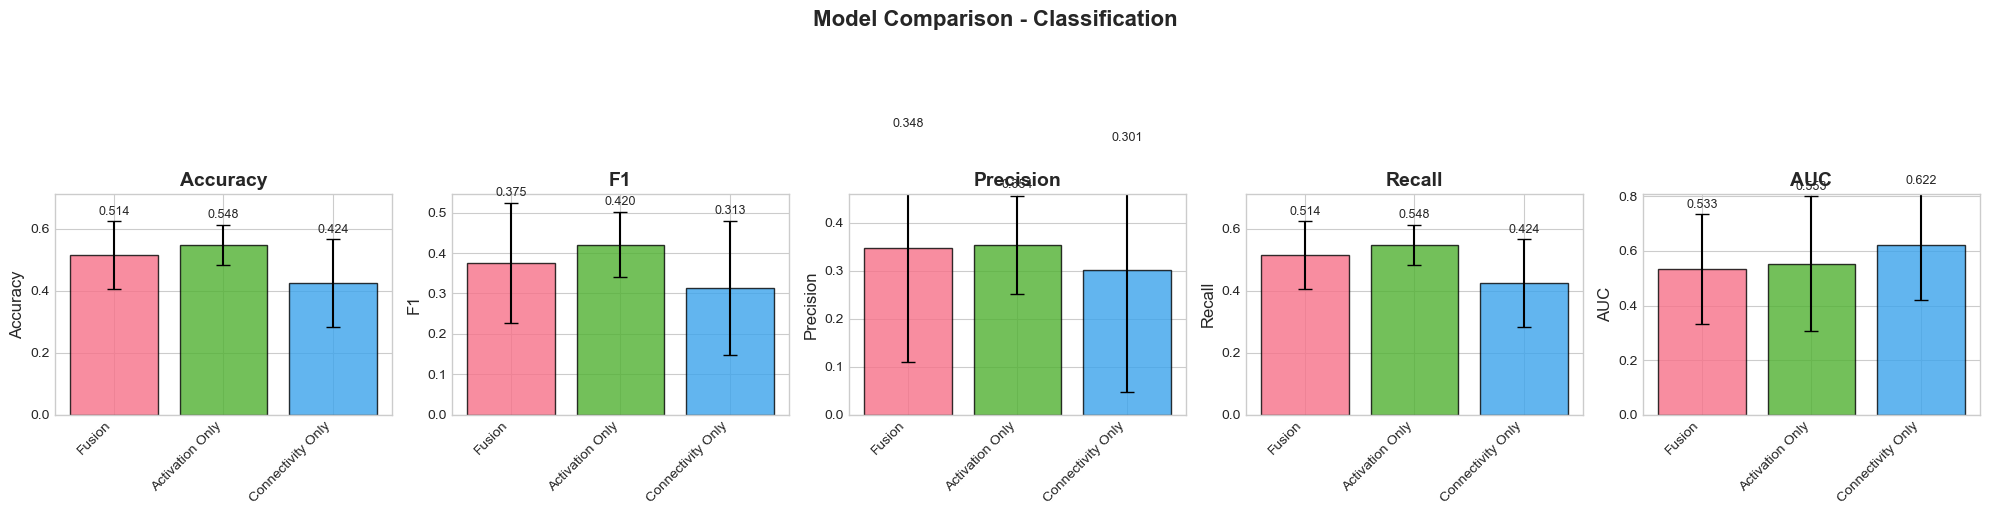

Saved: results_fmri\fold_performance_classification_20260217_162209.png


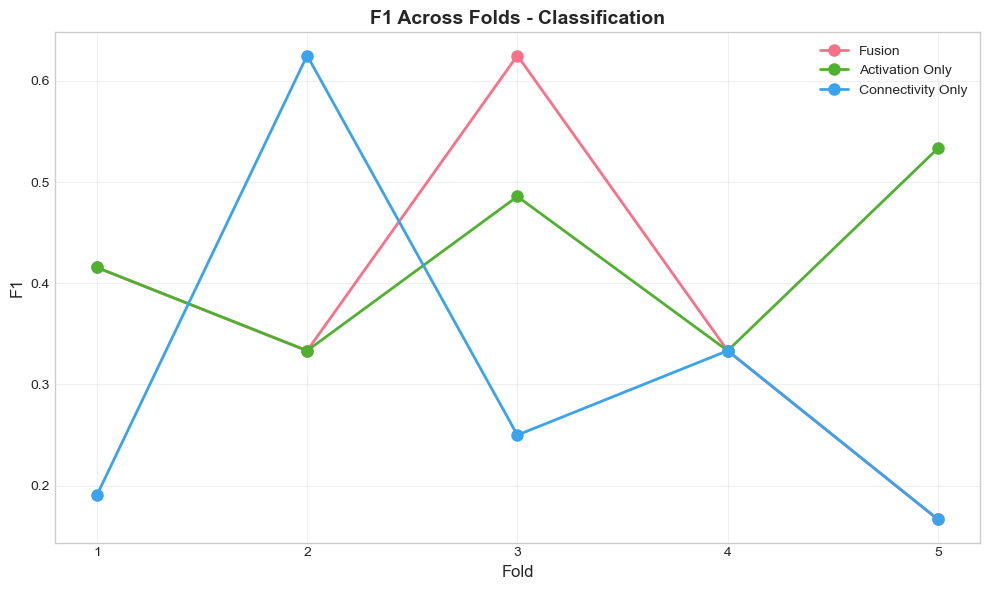

Saved: results_fmri\fusion_weights_20260217_162209.png


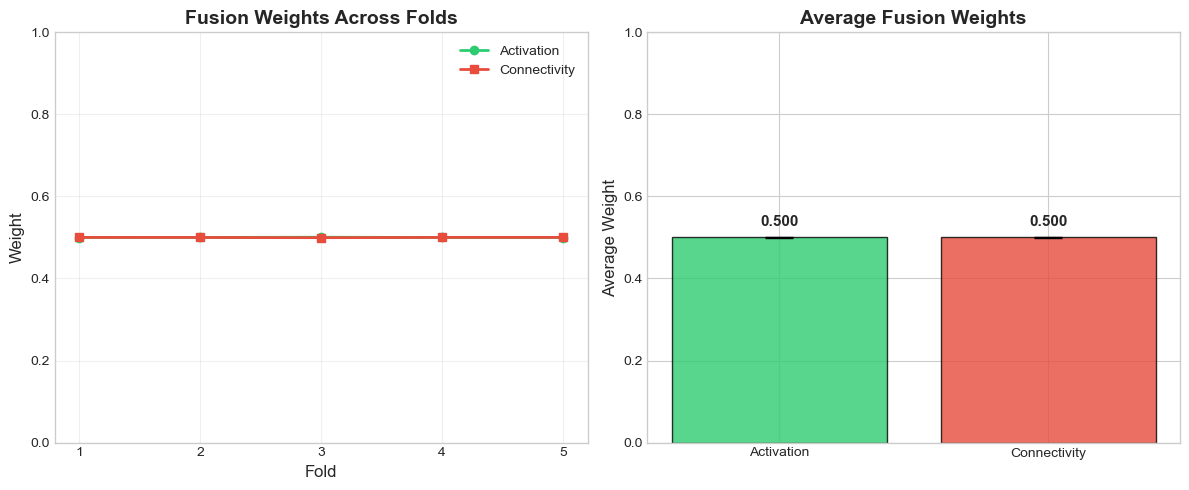

In [15]:
 # Plot classification results
print("GENERATING CLASSIFICATION PLOTS")
plot_model_comparison(clf_results, 'classification', config.output_dir, timestamp)
plot_fold_performance(clf_detailed_df, 'classification', config.output_dir, timestamp)
if clf_fusion_weights:
    plot_fusion_weights(clf_fusion_weights, config.output_dir, timestamp)

RUNNING REGRESSION EXPERIMENT
EXPERIMENT: REGRESSION
Device: cpu
Validation ratio: 0.15


FOLD 1/5
  Train: 20, Val: 4, Test: 7

--- Training FUSION ---
  Epoch  10: Loss=1.2491, Val_R2=0.0435, Val_RMSE=0.6426
  Early stopping at epoch 15
  Fusion weights: Activation=0.500, Connectivity=0.500
  Test: R2=-0.7110, RMSE=1.0584, MAE=0.8445

--- Training ACTIVATION ONLY ---
  Epoch  10: Loss=1.2909, Val_R2=-0.0856, Val_RMSE=0.6846
  Early stopping at epoch 15
  Test: R2=-0.4676, RMSE=0.9802, MAE=0.7887

--- Training CONNECTIVITY ONLY ---
  Epoch  10: Loss=1.3762, Val_R2=0.1956, Val_RMSE=0.5893
  Early stopping at epoch 15
  Test: R2=-0.5219, RMSE=0.9982, MAE=0.8243

FOLD 2/5
  Train: 21, Val: 4, Test: 6

--- Training FUSION ---
  Epoch  10: Loss=0.5501, Val_R2=-0.3054, Val_RMSE=1.9966
  Early stopping at epoch 15
  Fusion weights: Activation=0.500, Connectivity=0.500
  Test: R2=-0.3021, RMSE=1.0489, MAE=0.8395

--- Training ACTIVATION ONLY ---
  Epoch  10: Loss=0.5539, Val_R2=-0.1819, Val_R

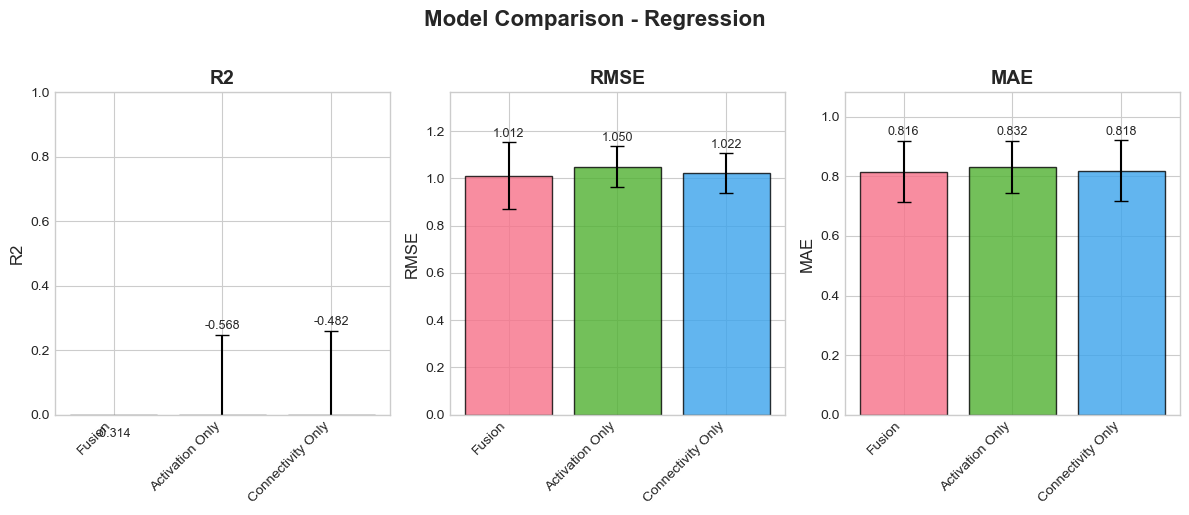

Saved: results_fmri\fold_performance_regression_20260217_162209.png


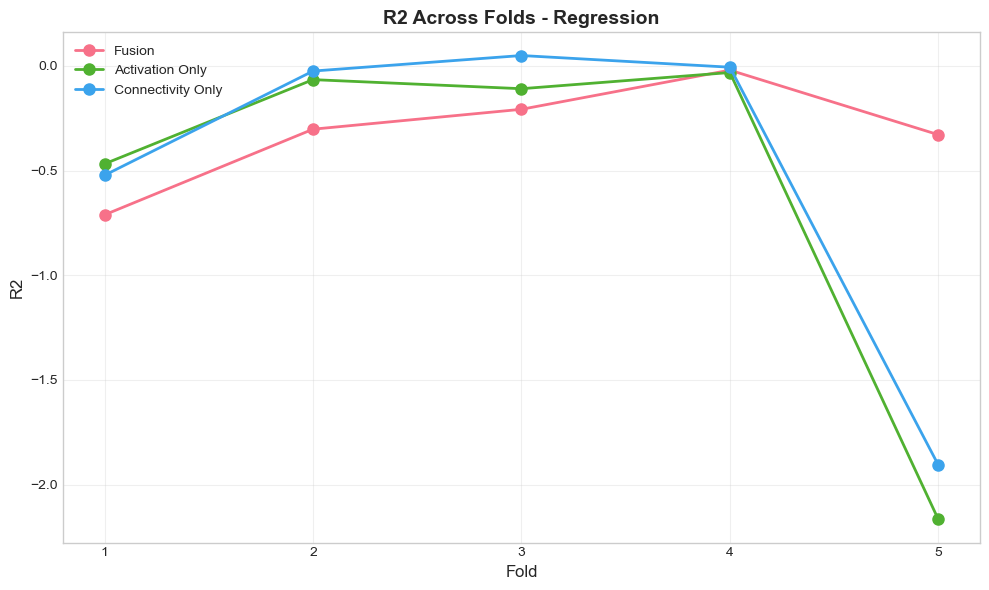

EXPERIMENT COMPLETE

Results saved to: results_fmri
Timestamp: 20260217_162209


In [16]:
 # Run regression experiment if applicable
if reg_labels and len(set(reg_labels.values())) > 1:
    print("RUNNING REGRESSION EXPERIMENT")
    reg_results, reg_fusion_weights = run_experiment(dataset, config, task='regression')
    reg_detailed_df = create_results_dataframe(reg_results, 'regression')
    reg_summary_df = create_summary_dataframe(reg_results, 'regression')
    print("REGRESSION RESULTS DATAFRAME")
    print("\nDetailed Results (per fold):")
    print(reg_detailed_df.to_string(index=False))
    print("\nSummary Statistics:")
    print(reg_summary_df[['Model', 'R2', 'RMSE', 'MAE']].to_string(index=False))
    save_results(reg_detailed_df, reg_summary_df, reg_fusion_weights, config.output_dir, 'regression', timestamp)
    print("GENERATING REGRESSION PLOTS")
    plot_model_comparison(reg_results, 'regression', config.output_dir, timestamp)
    plot_fold_performance(reg_detailed_df, 'regression', config.output_dir, timestamp)
else:
    print("\nSkipping regression experiment (no valid regression labels)")
print("EXPERIMENT COMPLETE")
print(f"\nResults saved to: {config.output_dir}")
print(f"Timestamp: {timestamp}")